This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/lyapunov.html).  I recommend having both windows open, side-by-side!


In [2]:
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (
    Jacobian,
    MathematicalProgram,
    Solve,
    ToLatex,
    Variable,
    Variables,
)
from pydrake.examples import PendulumParams
from pydrake.symbolic import Polynomial

from underactuated import running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

# Global stability of the simple pendulum via SOS

$E = 0.125 \dot\theta^2 + 4.905(1-c)$


$V = (2.440 - 4.879c_{0} + 0.077s_{0} \dot\theta_{0} + 2.465s_{0}^{2} + 2.440c_{0}^{2} + 0.126\dot\theta_{0}^{2})$


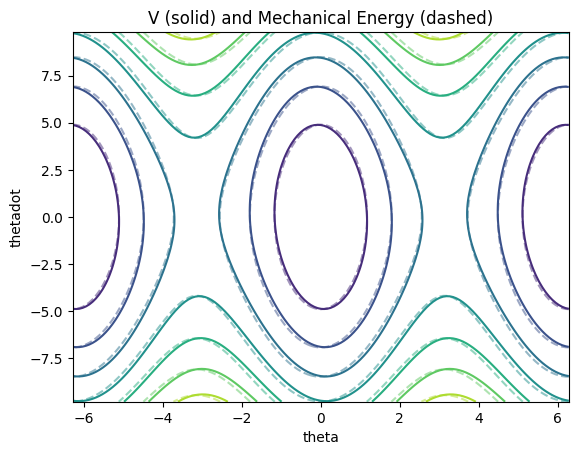

In [3]:
def global_pendulum():
    prog = MathematicalProgram()

    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s = prog.NewIndeterminates(1, "s")[0]
    c = prog.NewIndeterminates(1, "c")[0]
    thetadot = prog.NewIndeterminates(1, "\dot\\theta")[0]
    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s, c, thetadot])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c * thetadot,
        -s * thetadot,
        (-p.damping() * thetadot - p.mass() * p.gravity() * p.length() * s)
        / (p.mass() * p.length() * p.length()),
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    # TODO(russt): use the Groenber basis for s²+c²=1.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also
    # zero at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multiplying by s^2).
    constraint2 = prog.AddSosConstraint(
        -Vdot - L * (s**2 + c**2 - 1) - eps * (x - x0).dot(x - x0) * s**2
    )
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({s: 0, c: 1, thetadot: 0}) == 0
    )

    # Add V(theta=pi) = mgl, just to set the scale.
    constraint4 = prog.AddLinearConstraint(
        V.Substitute({s: 1, c: 0, thetadot: 0})
        == p.mass() * p.gravity() * p.length()
    )

    # Call the solver.
    result = Solve(prog)
    assert result.is_success()

    # Note that I've added mgl to the potential energy (relative to the textbook),
    # so that it would be non-negative... like the Lyapunov function.
    mgl = p.mass() * p.gravity() * p.length()
    display(
        Markdown(
            f"$E = {0.5*p.mass() * p.length()**2} \dot\\theta^2 + {mgl}(1-c)$\n"
        )
    )

    Vsol = Polynomial(result.GetSolution(V))
    Vsol
    display(
        Markdown(
            f"$V = {ToLatex(Vsol.RemoveTermsWithSmallCoefficients(1e-3).ToExpression())}$\n"
        )
    )

    # Plot the results as contour plots.
    nq = 151
    nqd = 151
    q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
    qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = 0.5 * p.mass() * p.length() ** 2 * QD**2 + mgl * (1 - np.cos(Q))
    Vplot = Q.copy()
    env = {s: 0.0, c: 1.0, thetadot: 0}
    for i in range(nq):
        for j in range(nqd):
            env[s] = np.sin(Q[i, j])
            env[c] = np.cos(Q[i, j])
            env[thetadot] = QD[i, j]
            Vplot[i, j] = Vsol.Evaluate(env)

    # plt.rc("text", usetex=True)
    fig, ax = plt.subplots()
    ax.contour(Q, QD, Vplot)
    ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
    ax.set_xlabel("theta")
    ax.set_ylabel("thetadot")
    ax.set_title("V (solid) and Mechanical Energy (dashed)")


global_pendulum()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5ec0aeb-d006-4689-a009-180923e76318' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>